In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
# Import DATA Set (.mat file)
data = sio.loadmat('sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)

# sentimentdataset.mat file contains 3 matlab variables
# bagofword: 198 X 29717 double
# sentiment: 198 X 1     double
# word:      29717 X 1  cell -> Only use 2000 cases in this class.

bagofword = data['bagofword'];
sentiment = data['sentiment']; 
sentiment = sentiment.astype(int);
words = data['word'];

# Convert MATLAB Cell into python array
word = []
for n in range(2000):
    word = word + [str(''.join(letter)) for letter in words[n][0]]

In [3]:
cell = 10;
replication = 5;
numTesting = 50;
numWord = 100;

trainingAccuracy = np.zeros((replication, 10));
testingAccuracy = np.zeros((replication, 10));
avgTraining = np.zeros((cell, 1));
stdTraining = np.zeros((cell, 1));
avgTesting = np.zeros((cell, 1));
stdTesting = np.zeros((cell, 1));

h = 0.5;
threshold = 0.1;

for M in range(1,cell+1):
    N = M*10;
    for rep in range(replication):
        sample = np.random.permutation(np.arange(198));
        
        numFeatures = numWord + 1;
        X = np.ones((np.size(sample),numFeatures));
        tempMat = bagofword[sample];
        tempMat = tempMat[:,range(numWord)];
        X[:,range(1,numFeatures)] = tempMat;
        Y = sentiment[sample];
        
        theta = np.ones((numFeatures,1));
        itr = 500;
        
        cntItr = 0;
        for k in range(itr):
            thetanew = np.zeros((numFeatures,1));
            for i in range(numFeatures):
                temp = 0;
                for j in range(N):
                    Xtheta = 0;
                    Xtheta = np.dot(X[j,:], theta)[0];
                    temp = temp + X[j,i] * ( Y[j][0] - np.exp(Xtheta) / (1 + np.exp(Xtheta)));
                temp = temp * h;
                thetanew[i] = theta[i] + temp;
            diff = np.sum(np.abs(theta-thetanew));
            if diff/(np.sum(np.abs(theta))) < threshold:
                break;
            cntItr = cntItr + 1;
            theta = thetanew;
        
        probsSentiment = np.zeros((198,2));
        for i in range(198):
            Xtheta = np.dot(X[i,:], theta)[0];
            probsSentiment[i,0] = 1 / (1 + np.exp(Xtheta));
            probsSentiment[i,1] = 1 - 1 / (1 + np.exp(Xtheta));
        
        estSentiment = np.zeros((198,1));
        for i in range(198):
            if probsSentiment[i,0] > probsSentiment[i,1]:
                estSentiment[i] = 0;
            else:
                estSentiment[i] = 1;
        
        cntCorrect = 0;
        for i in range(N):
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        trainingAccuracy[rep,M-1] = cntCorrect / float(N);
        
        cntCorrect = 0;
        for i in range(N,N+numTesting):
            if estSentiment[i] == Y[i]:
                cntCorrect = cntCorrect + 1;
        testingAccuracy[rep,M-1] = cntCorrect / float(numTesting);
        
    avgTraining[M-1] = np.mean(trainingAccuracy[:,M-1]);
    avgTesting[M-1] = np.mean(testingAccuracy[:,M-1]);
    stdTraining[M-1] = np.std(trainingAccuracy[:,M-1]);
    stdTesting[M-1] = np.std(testingAccuracy[:, M-1]);

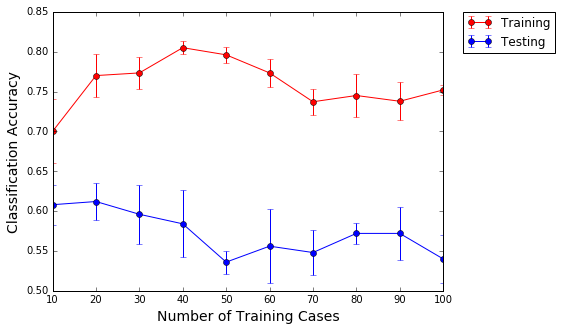

In [4]:
plt.figure(1, figsize = (7,5));
plt.errorbar(np.dot(10,range(1,cell+1)), avgTraining, yerr = stdTraining/np.sqrt(replication), fmt='-o', color='r', label="Training");
plt.errorbar(np.dot(10,range(1,cell+1)), avgTesting, yerr = stdTesting/np.sqrt(replication),fmt='-o', label="Testing");

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of Training Cases', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)

plt.show();